# Projections Experiment

Investigate the difference between different methods for Projecting High-Dimensional data into lower dim space for visualization

Will look at: 
- PCA- linear, orthogonal projection of data into a lower dimensional vector subspace
- T-SNE- with a specified random seed?
- AutoEncoders- try out a linear version (to approximate PCA?) and then test out the affect of more neurons/layers & alternate activations (tanh, swish, sigmoidal, etc.)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset     #wraps the "torch.utils.data.Dataset" in a nice iterable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


# Download and Use MNIST 
data_dir = "../../data"

training_data = MNIST(
    root=data_dir, #where to download
    train=True, #flag for train or test subset
    download=False, #will download from scratch if True
    transform=ToTensor(), #can specify a pipeline for transforming (also provides a `target_transform` for modifying labels)
)

test_data = MNIST(
    root=data_dir,
    train=False,
    download=False,
    transform=ToTensor()
)

# Create Dataloaders for Combined Set + The Train & Test Sets
BATCH_SIZE = 64 #may change depending on learning

dataset = ConcatDataset([training_data, test_data]) #total dataset, for PCA & T-SNE

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE) 
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Set Compute Device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Print Batch Shapes (from DataLoader)

len(next(iter(data_loader))[1])
batch_items = next(iter(data_loader))
print("x: ", batch_items[0].shape, "\ny: ", batch_items[1].shape) #shape of batches of data (x, y) or (data, labels)


x:  torch.Size([64, 1, 28, 28]) 
y:  torch.Size([64])


In [3]:
# Convert a Single Data Tensor into a flattened vector
x = dataset.__getitem__(1)[0] #access data for a single value

x = torch.flatten(x)

x.shape


torch.Size([784])

In [43]:
dataset.datasets

[Dataset MNIST
     Number of datapoints: 60000
     Root location: ../../data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../../data
     Split: Test
     StandardTransform
 Transform: ToTensor()]

In [2]:
# Accessing MNIST (Image, Label) pairs through `dataset` object
dataset.__getitem__(70000-1) #access any instance within a dataset

dataset.__getitem__(1)[0] # X data (tensor describing image)
dataset.__getitem__(1)[1] # y data (label for image class)

0

In [3]:
# Convert Whole dataset into a matrix (70000 x 784) dims -- for PCA

data_matrix = [] #slow method of creating data matrix
labels_vector = []

for D in dataset.datasets:
    for instance in D:
        tensor, label = instance[0], instance[1]
        x = torch.flatten(tensor) #converts [1, 28, 28] tensors into 784 len vectors
        x = x.numpy()
        data_matrix.append(x) #list of 70k instances, each of length 784
        labels_vector.append(label)

# PCA & T-SNE Calls

apply the functions from `DimReducers` to the dataset (both work off of the Data Matrix & can be visualized)


In [4]:
# PCA from Script
from DimReducers import PCA

pca = PCA() #init class, saved in external file

# Compute PCA Projects of Full Dataset in 2d & 3d
dm_pca_2d = pca.compute(data_matrix, 2) #returns projected datamatrix via PCA
dm_pca_3d = pca.compute(data_matrix, 3)


In [6]:
# T-SNE from sklearn (ref- https://plotly.com/python/t-sne-and-umap-projections/)
from sklearn.manifold import TSNE

# Instantiate TSNE & Project
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, n_iter=1000
        , random_state=42, n_jobs=-1)
dm_tsne = tsne.fit_transform(data_matrix) #needs fit to matrix, takes about 3.9min or so (for 70k MNIST instances on archbox w 1 job/CPU)
dm_tsne

/home/ckg/miniconda3/envs/pt/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ckg/miniconda3/envs/pt/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ 20.386683  ,  -0.72310007],
       [ 34.232502  ,  16.039686  ],
       [-42.325043  ,  17.819483  ],
       ...,
       [-46.015366  ,  -8.674511  ],
       [  8.891364  ,   8.170753  ],
       [ 20.817743  ,  23.910719  ]], dtype=float32)

# Autoencoder

Torch module to create an autoencoder to reproduce MNIST Instances, compresses representations into 2 or 3 Dimensions for Viz?


In [114]:
# Training Logger
import logging 

logging.basicConfig(filename="training_logs.log", format='%(asctime)s %(message)s', filemode='w')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG) #set threshold, enables logging


logger.info("Logger Instantiated")

In [5]:
dataset.__getitem__(1)[0].shape

for data in data_loader: #can use full set here, not trying to get test set accuracy
    
    # Load in Data & Compute Loss (after forward)
    inp, _ = data #no need for the label in autoencoder training
    inp = inp.to(device)
    print(inp.shape)
    break

torch.Size([64, 1, 28, 28])


In [68]:
# Autoencoder for MNIST w Convolutions

class VanillaAutoencoder(nn.Module):
    def __init__(self):
        super(VanillaAutoencoder,self).__init__()
        # Sequential as per- https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        self.encoder = nn.Sequential(
            nn.Linear(784, 5000),
            # nn.ReLU(True),
            nn.Tanh(),
            nn.Linear(5000, 100),
            # nn.ReLU(True),
            nn.Tanh(),
            nn.Linear(100, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 100),
            # nn.ReLU(True),
            nn.Tanh(),
            nn.Linear(100, 5000),
            # nn.ReLU(True),
            nn.Tanh(),
            nn.Linear(5000, 784),
            nn.Tanh()
        )

    def forward(self, x):
        thought = self.encoder(x)
        reconstruction = self.decoder(thought)
        return reconstruction


# Training, Loss & Optimizer
model = VanillaAutoencoder()
model.to(device)

mse_loss = nn.MSELoss()

learning_rate = 0.001
momentum = 0.3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


# Config Num of Epochs + Interval for Printing
# num_epochs = 500
# num_epochs = 75
num_epochs = 40

printfo_steps = 10
printfo_steps = 1


# Train it up
for epoch in range(num_epochs):
    # for data in train_loader:
    for data in data_loader: #can use full set here, not trying to get test set accuracy
        
        # Load in Data & Compute Loss (after forward)
        inp, _ = data #no need for the label in autoencoder training
        inp = inp.to(device)
        inp = torch.flatten(inp, start_dim=2)
        output = model(inp)

        loss = mse_loss(output, inp) #loss is computed based on the reconstruction of the original image! (i.e; x_train = actual)

        # Update Net Params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Printfo Every N Steps
    if epoch % printfo_steps == 0:
        print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


# Save Model -- Name Based off Architecture + Num Epochs
from datetime import datetime

save_path = f"models/VanillaAutoencoder_{num_epochs}epochs_{str(datetime.now())}"
torch.save(model.state_dict(), save_path)


epoch [1/40], loss: 0.0814
epoch [2/40], loss: 0.0713
epoch [3/40], loss: 0.0689
epoch [4/40], loss: 0.0683
epoch [5/40], loss: 0.0680
epoch [6/40], loss: 0.0679
epoch [7/40], loss: 0.0678
epoch [8/40], loss: 0.0677
epoch [9/40], loss: 0.0677
epoch [10/40], loss: 0.0676
epoch [11/40], loss: 0.0676
epoch [12/40], loss: 0.0675
epoch [13/40], loss: 0.0674
epoch [14/40], loss: 0.0673
epoch [15/40], loss: 0.0671
epoch [16/40], loss: 0.0669
epoch [17/40], loss: 0.0667
epoch [18/40], loss: 0.0665
epoch [19/40], loss: 0.0662
epoch [20/40], loss: 0.0658
epoch [21/40], loss: 0.0654
epoch [22/40], loss: 0.0649
epoch [23/40], loss: 0.0644
epoch [24/40], loss: 0.0639
epoch [25/40], loss: 0.0633
epoch [26/40], loss: 0.0627
epoch [27/40], loss: 0.0621
epoch [28/40], loss: 0.0616
epoch [29/40], loss: 0.0610
epoch [30/40], loss: 0.0605
epoch [31/40], loss: 0.0599
epoch [32/40], loss: 0.0594
epoch [33/40], loss: 0.0590
epoch [34/40], loss: 0.0586
epoch [35/40], loss: 0.0582
epoch [36/40], loss: 0.0579
e

In [ ]:
# Sample a Reconstruction w Autoencoder

ins = dataset.__getitem__(4)[0] #access data for a single value
ins = torch.flatten(ins, start_dim=1) #convert 28x28 mats (for img data) to vec of 784
ins = ins.to(device)
ins = ins.unsqueeze(dim=0)
print(ins.shape)
out = model(ins) #works nicely w a inp shape of [batch_size, 784] but also generalizes up

out = out.to("cpu").detach().numpy() #get reconstruction output correct
out = out.reshape(28, 28)
plt.imshow(out)

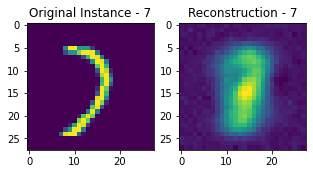

In [79]:
# Function to Plot Reconstruction and Original Image

def plot_img_recon(model, idx):
    x, y = dataset.__getitem__(idx)[0], dataset.__getitem__(idx)[1]
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(5, 5))

    # Plot Original
    ax[0].imshow(x.squeeze(0))
    ax[0].set_title(f"Original Instance - {y}")

    # Compute Reconstruction and Plot
    x = x.reshape(1, 784)
    x = x.to(device)
    out = model(x)

    out = out.reshape(28, 28).to("cpu").detach().numpy() #get output, reshape to img matrix, move to CPU as a Numpy Array
    ax[1].imshow(out)
    ax[1].set_title(f"Reconstruction - {y}")


plot_img_recon(model, 140)


# Visualize 

Plot the Lower Dimensionality Data


In [18]:
# Utils to plot data in diff dimensions (2D and 3D)
from viz_utils import *


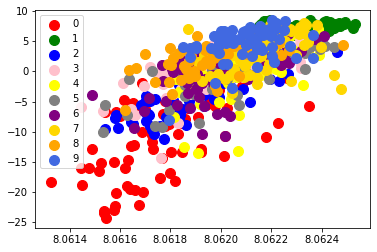

In [58]:
# Matplotlib, kinda mid
import matplotlib.pyplot as plt 


# Parse Projected Matrix for correct data
n_instances = 700 #number of instances from data to plot (max=70k)
x, y = dm_pca[:n_instances, 0].real, dm_pca[:n_instances, 1].real
n_labels = labels[:n_instances]
cdict = {0 : "red", 1 : "green", 2 : "blue", 3 : "pink", 4 : "yellow", 5 : "grey", 6 : "purple", 7 : "gold", 8 : "orange", 9 : "royalblue"}

fig, ax = plt.subplots()
for g in np.unique(n_labels):
    ix = np.where(n_labels==g)
    ax.scatter(x[ix], y[ix], c=cdict[g], label=g, s=100)
ax.legend()
plt.show()




In [5]:
# Plotly 2D Scatter - Iris Data

import plotly.express as px
df = px.data.iris()
x, y = df["sepal_length"], df["sepal_width"]

fig = px.scatter(x=x, y=y)
fig.show()

In [17]:
# Plotly 3d Scatter - Iris Data (upstream docs- https://plotly.com/python/3d-scatter-plots/)
df #we can pass in a pandasframe and reference columns like in below syntax

fig = px.scatter_3d(df, x="sepal_length", y="sepal_width", z="petal_width",
            size="petal_length", color="species", symbol="species"
       )
fig.show()

In [6]:
# Plotly 3D Scatter - MNIST Vals


# Despite calling `real` attribute of matrix, the `imag` (imaginary for complex nums) val never has anything (real is only thing to care about)
# x, y, z = dm_pca[:n_instances, 0].real, dm_pca[:n_instances, 1].real, dm_pca[:n_instances, 2].real
# y_labels = labels_vector[:n_instances]

x, y, z, nl = get_3d_items(dm_pca_3d, labels_vector, 700)

df = px.data.iris()
fig = px.scatter_3d(x=x, y=y, z=z, color=nl, opacity=0.7)
fig.show()



In [30]:
# Plotly 2D Scatter - MNIST Projected
import plotly.express as px


# n_plt_items, nl = get_2d_items(dm_tsne, labels_vector, 10000)
x, y, nl = get_2d_items(dm_pca_2d, labels_vector, 10000)
plot_title = "PCA - 2D"

fig = px.scatter(x=x, y=y, color=nl, symbol=nl, title=plot_title, opacity=0.7)
fig.show()

In [76]:
dm_tsne.shape

(70000, 2)

In [92]:
t = np.array([[1, 2], [3, 4]])

[i[1] for i in t]

[2, 4]